# Bibs

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(16, 6)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Dataset

In [2]:
df = pd.read_csv(r"C:\Users\user\Documents\DataAnalyse\TimeSeriasForecasting\Datasets\monthly-car-sales.csv")

In [3]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [4]:
df.tail()

,Month,Sales
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180
107,1968-12,14577


In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

<AxesSubplot:>

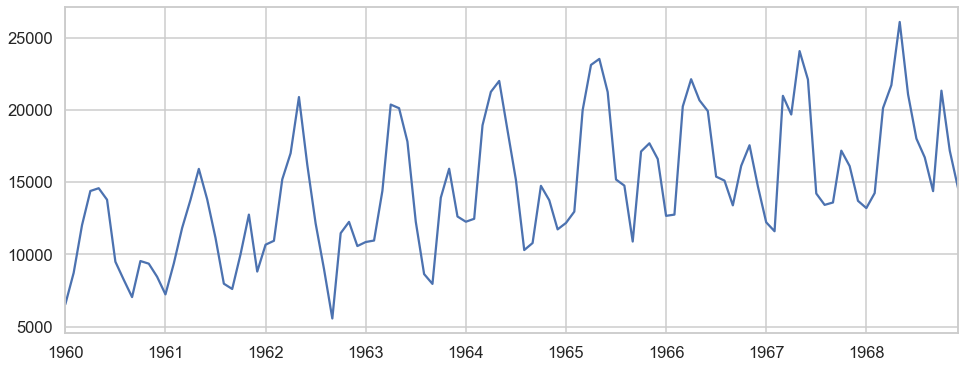

In [6]:
df['Sales'].plot()

<AxesSubplot:>

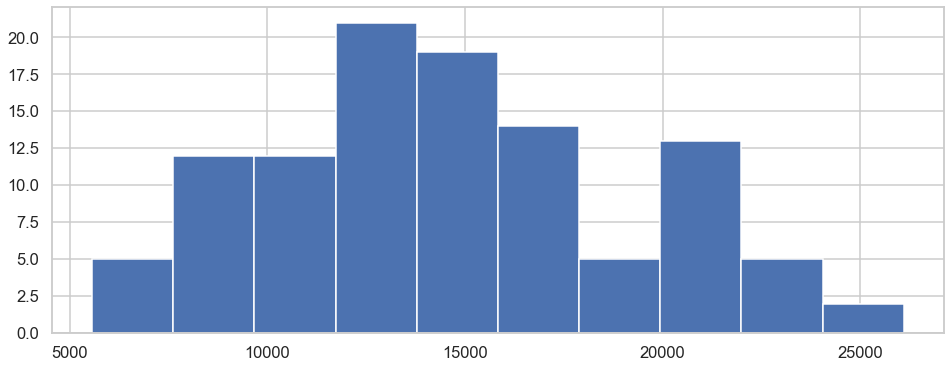

In [7]:
df["Sales"].hist()

# Task №1

## seasonal_decompose

Decompose into components using the **seasonal_decompose** function

In [8]:
resalt_decomp = seasonal_decompose(x=df['Sales'], model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

<AxesSubplot:>

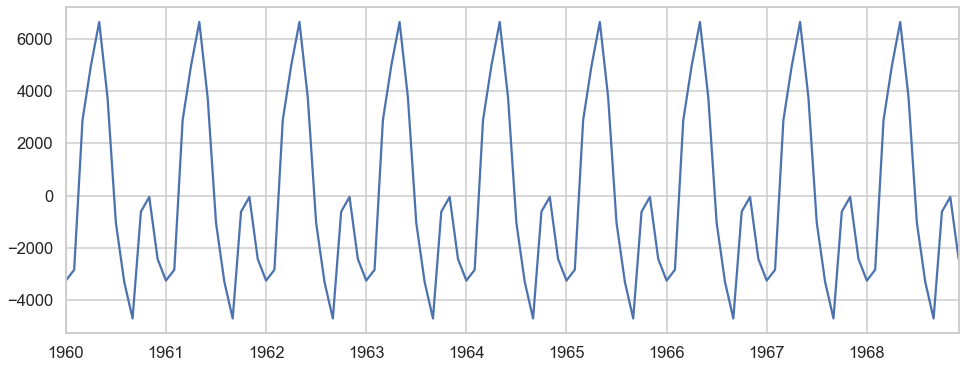

In [9]:
resalt_decomp.seasonal.plot()

<AxesSubplot:>

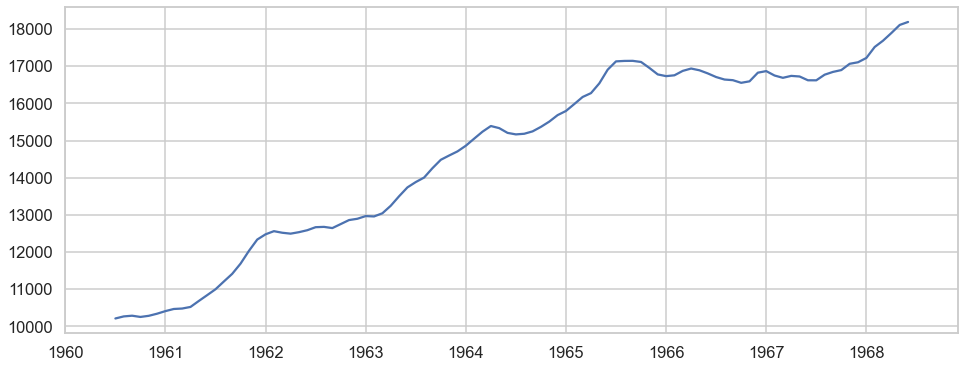

In [10]:
resalt_decomp.trend.plot()

<AxesSubplot:>

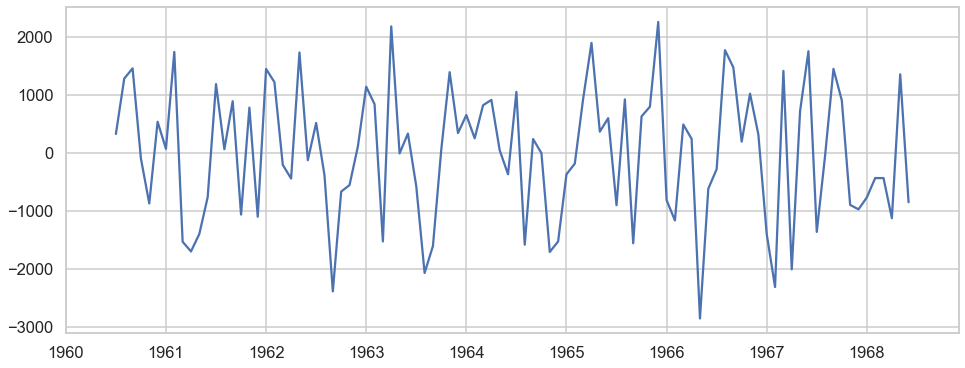

In [11]:
resalt_decomp.resid.plot()

<AxesSubplot:>

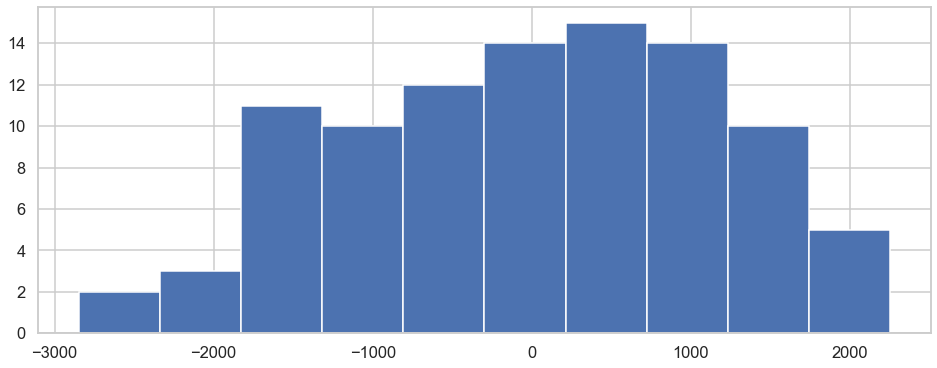

In [12]:
resalt_decomp.resid.hist()

## Augmented Dickey Fuller Test (ADF Test)

Let's check if the time series is stationary.

In [13]:
result = adfuller(df['Sales'],maxlag=12)
print('p-value: %f' % result[1])

p-value: 0.663269


In [14]:
result

(-1.2238127661752862,
 0.6632691049832858,
 12,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 1687.6904256398777)

    H_0 - there is unit root
    H_a - there is no unit root

p-value > 0,5 => H_0 is not rejected, the series is not stationary.

Let's try to make one differentiation.

In [15]:
df['diff'] = df['Sales'].diff()

result = adfuller(df['diff'].dropna(), maxlag=12)
print('p-value: %f' % result[1])

p-value: 0.000000


In [16]:
result

(-6.199799230800695,
 5.8447525992768446e-08,
 11,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 1670.921459217392)

p-value < 0,5 => H_0  can be rejected, the series is stationary 

<AxesSubplot:>

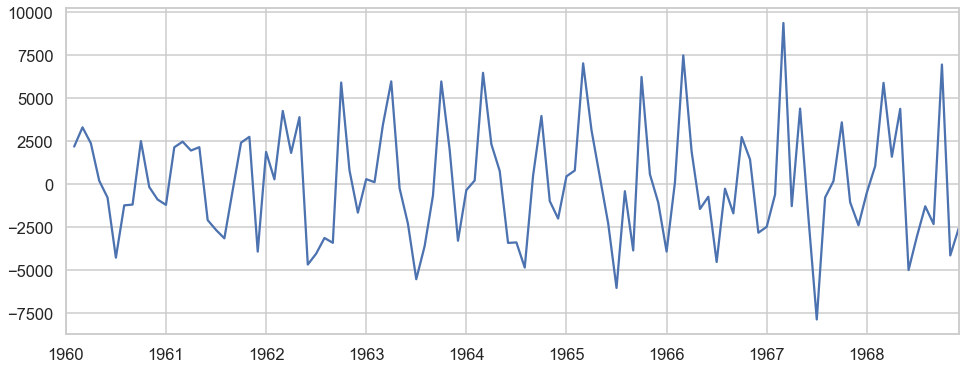

In [17]:
df['diff'].plot()

In [18]:
resalt_decomp_diff = seasonal_decompose(df['diff'].dropna(), period=12)

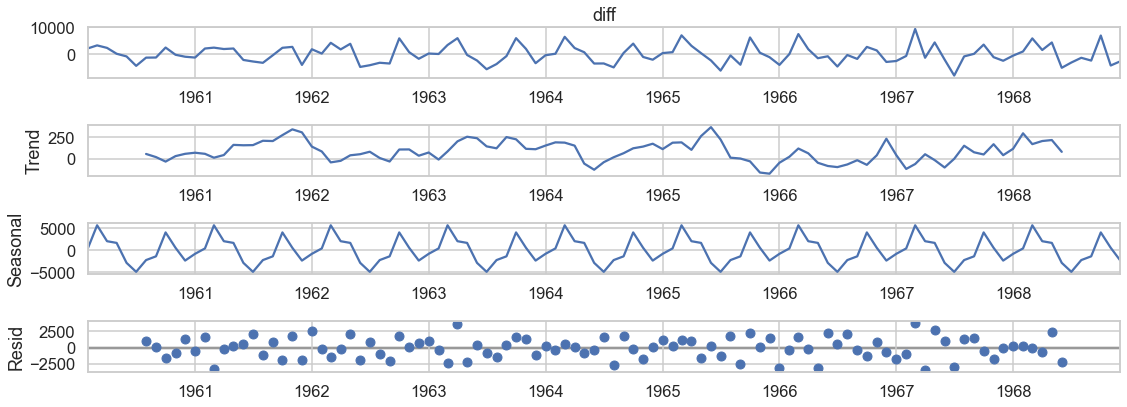

In [19]:
resalt_decomp_diff.plot()
plt.show()

<AxesSubplot:>

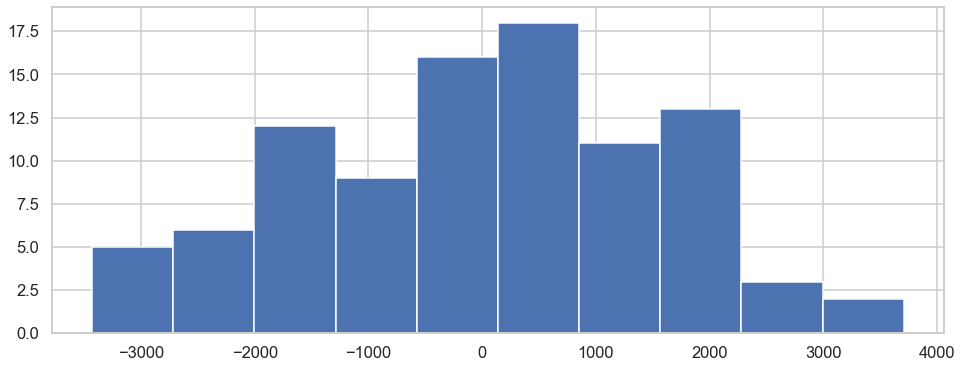

In [20]:
resalt_decomp_diff.resid.hist()

<mark>Consequently, we can conclude that the parameter **d** in the ARIMA model will be equal to 1.</mark>

# Task №2

Make autocorrelation and partial autocorrelation plots using plot_acf and plot_pacf functions.


    If the RuntimeWarning: invalid value encountered in sqrt appears when using the plot_pacf function, you can change         the default value of the method used to calculate the partial autocorrelation. You can read about methods here:             https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html

    Try using method = 'ldadjusted' 

## autocorrelation (ACF)

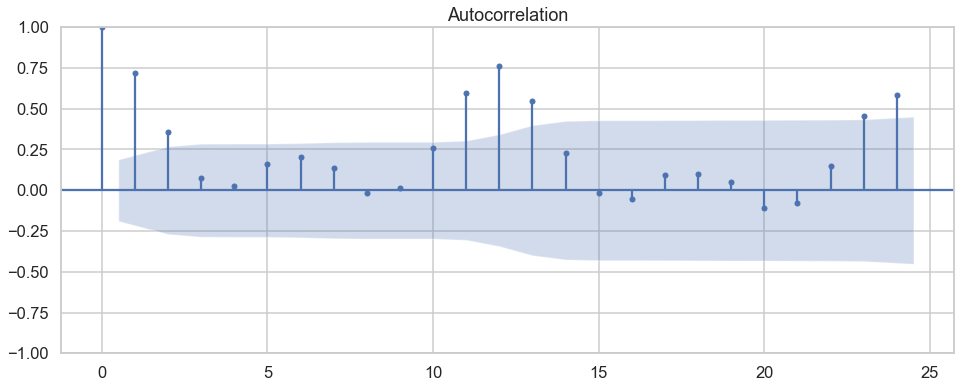

In [21]:
plot_acf(df['Sales'],lags=24)
plt.show()

Оптимальное значение **q** проверим позже при использовании auto_arima. 

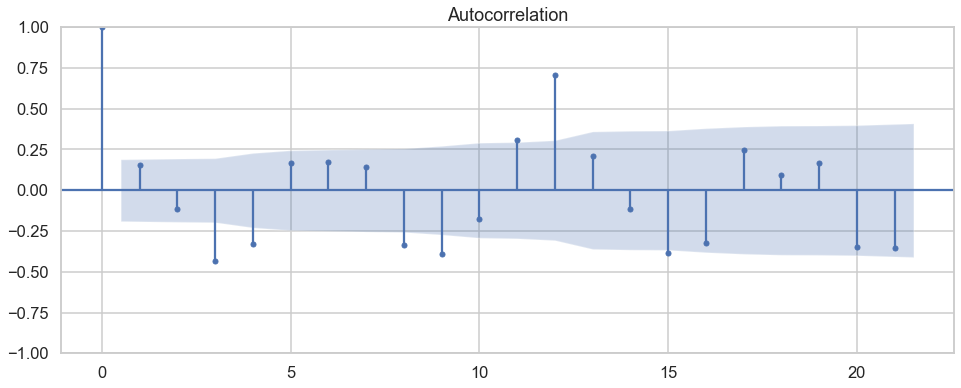

In [22]:
plot_acf(df['diff'].dropna())
plt.show()

## partial autocorrelation (PACF)

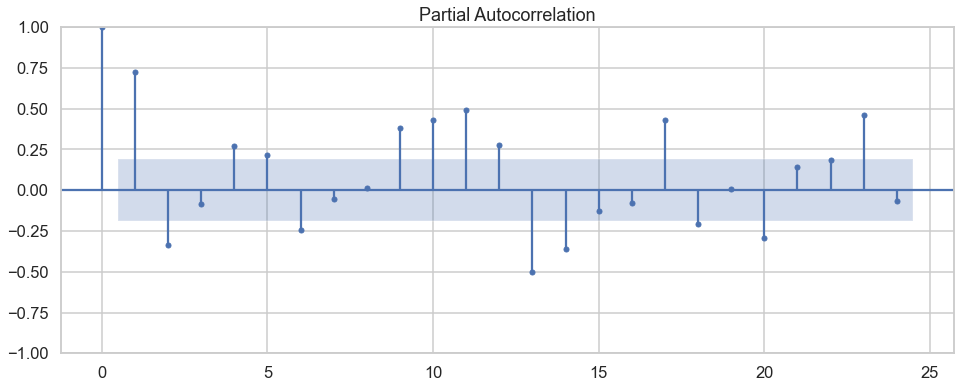

In [23]:
plot_pacf(df['Sales'],method='ldadjusted', lags=24)
plt.show()


For ARIMA  is a  **p** value

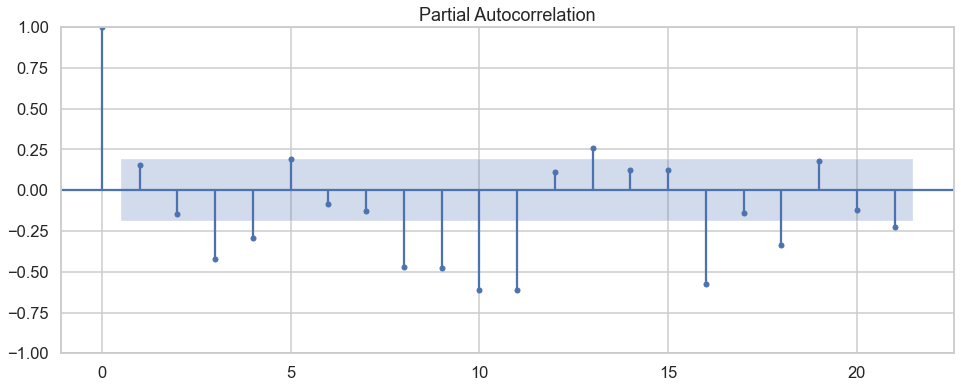

In [24]:
plot_pacf(df["diff"].dropna(),method="ldadjusted")
plt.show()

## ARIMA

In [25]:
# split data into train and test

# what is the size of 80% ? 
size = int(len(df)*0.8)

# use 80% for train and 20% for test

train, test = df[0:size], df[size:]
print(f'Length of train is {len(train)} and lenght of test is {len(test)}')

Length of train is 86 and lenght of test is 22


Определим для простой модели ARIMA три параметра **q,d,p** согласно нашему исследованию выше.


In [26]:
p = 3 # порядок компоненты AR (PACF)
d = 1 # порядок интегрированного ряда, мы привели ряд к стационарному 1 раз продифференцировав
q = 2 # порядок компонетны MA (ACF)

order = (p,d,q)

In [27]:
model = ARIMA(train['Sales'], order=order)
model_fit = model.fit(cov_type = 'approx')
preds = model_fit.forecast(len(test))

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   86
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -782.955
Date:                Fri, 17 Jun 2022   AIC                           1577.910
Time:                        16:51:54   BIC                           1592.566
Sample:                    01-01-1960   HQIC                          1583.805
                         - 02-01-1967                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8728      0.136      6.425      0.000       0.607       1.139
ar.L2         -0.8902      0.137     -6.477      0.000      -1.160      -0.621
ar.L3         -0.0698      0.132     -0.529      0.597      -0.329       0.189
ma.L1         -0.7720      0.062    -12.528      0.000      -0.893      -0.651
ma.L2          0.9329      0.063     14.693      0.000       0.808       1.057
sigma2      6.859e+06   4.76e-10   1.44e+16      0.000    6.86e+06    6.86e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.97   Prob(JB):                         0.95
Heteroskedasticity (H):               1.40   Skew:                             0.04
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number  2e+33. Standard errors may be unstable.
"""

Note that the coefficient at **ar.L3** is not significant, and does not contribute much to the model.

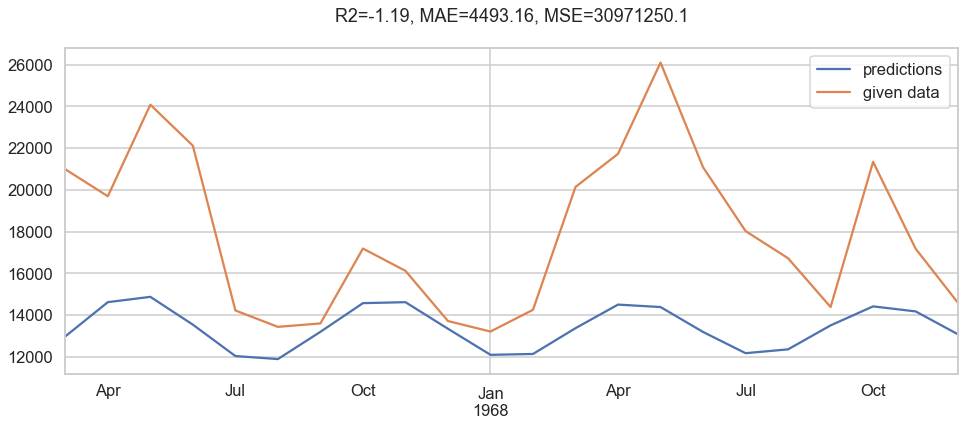

In [29]:
preds.plot(label='predictions')
test['Sales'].plot(label='given data')

r2 = np.round(r2_score(test["Sales"], preds),2)
mae = np.round(mean_absolute_error(test["Sales"], preds),2)
mse = np.round(mean_squared_error(test["Sales"], preds),2)
               
mse
plt.legend()
plt.title(f"R2={r2}, MAE={mae}, MSE={mse}\n")
plt.show()

## SARIMA

This model is based on the classical family of ARIMA models, but it also takes into account seasonality (S - seasonal). It has more parameters than the previous model. These parameters can be divided into two groups:

   - Trend Parameters
   - Seasonality parameters
   
The trend parameters are the same parameters as the ARIMA model:

   - p - autoregressive order
   - d - differentiation order
   - q - moving average order
   
Seasonality parameters:

   - P - seasonal order of autoregression
   - D - seasonal differentiation order
   - Q - seasonal order of the moving average
   - m - single period size

SARIMA(p,d,q)(P,D,Q)m

In [30]:
seasonal_order = (2,1,0,12)

In [31]:
SARIMA_model = ARIMA(train["Sales"], order=order, seasonal_order=seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()

predictions = SARIMA_model_fit.forecast(len(test))


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


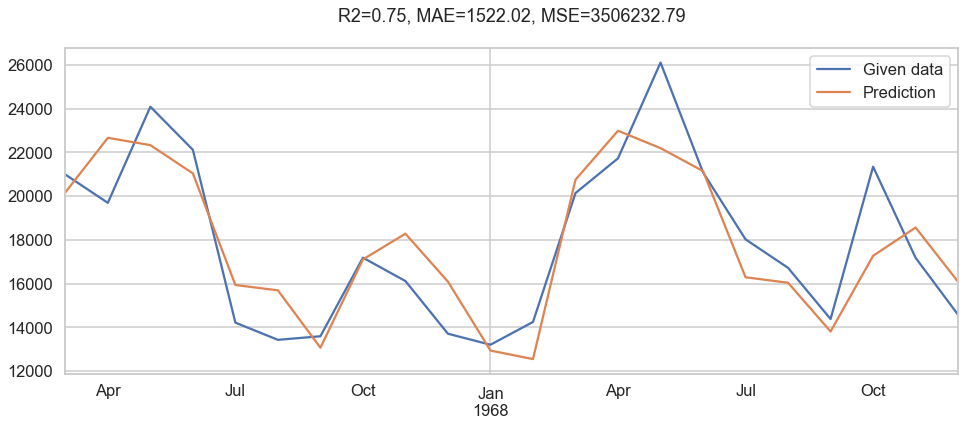

In [32]:
r2 = np.round(r2_score(test["Sales"], predictions),2)
mae = np.round(mean_absolute_error(test["Sales"], predictions),2)
mse = np.round(mean_squared_error(test["Sales"], predictions),2)

test["Sales"].plot(label="Given data")
predictions.plot(label="Prediction")
plt.legend()
plt.title(f"R2={r2}, MAE={mae}, MSE={mse}\n")
plt.show()

## SARIMAX

Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors

In [33]:
df['month']=df.index.month

In [34]:
train, test = df[0:size], df[size:]

In [35]:
sarimax_model = SARIMAX(train['Sales'], order = order,
                       seasonal_order=seasonal_order,
                        exogenous = train['month'])

sarimax_model_fit = sarimax_model.fit()
predictions = sarimax_model_fit.forecast(len(test))

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


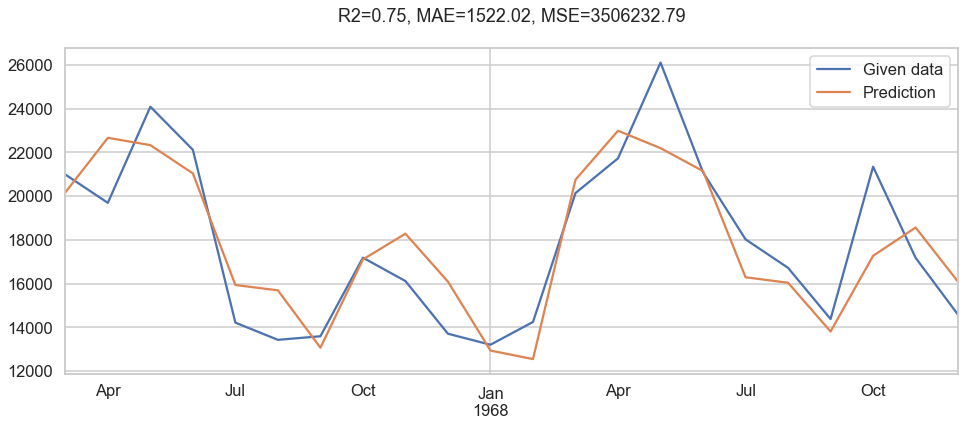

In [36]:
r2 = np.round(r2_score(test["Sales"], predictions),2)
mae = np.round(mean_absolute_error(test["Sales"], predictions),2)
mse = np.round(mean_squared_error(test["Sales"], predictions),2)

test["Sales"].plot(label="Given data")
predictions.plot(label="Prediction")
plt.legend()
plt.title(f"R2={r2}, MAE={mae}, MSE={mse}\n")
plt.show()

# Task №3

Using auto_arima find the optimal set of parameters, train the model on it (on training data) and make predictions for the test. 

Make graphs and calculate quality of predictions, using metrics r2_score and mean_absolute_error.

## auto_arima

In [63]:
SARIMA_model = auto_arima(df["Sales"], 
                         start_p=0, max_p=9,
                         start_q=0, max_q=9,
                         test='adf',
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, max_P=9,
                         start_Q=0, max_Q=9,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=None, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,
                         method="nm")

In [64]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -845.374
Date:                            Fri, 17 Jun 2022   AIC                           1698.748
Time:                                    17:03:42   BIC                           1709.005
Sample:                                         0   HQIC                          1702.894
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9703      0.011     90.047      0.000       0.949       0.991
ma.L1         -0.8917      0.036    -24.588      0.000      -0.963      -0.821
ma.S.L12      -0.4097      0.100     -4.107      0.000      -0.605      -0.214
sigma2      2.611e+06   1.75e-09   1.49e+15      0.000    2.61e+06    2.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.65   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.10   Prob(JB):                         0.79
Heteroskedasticity (H):               1.20   Skew:                             0.13
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.72e+31. Standard errors may be unstable.
"""

In [65]:
#SARIMA_model.get_params()

In [66]:
order = SARIMA_model.get_params().get("order")
seasonal_order = SARIMA_model.get_params().get("seasonal_order")
print(f"oder={oder}, seasonal_order={seasonal_order}")

oder=(1, 0, 1), seasonal_order=(0, 1, 1, 12)


In [67]:
SARIMA_model = ARIMA(train["Sales"], order=order, seasonal_order=seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()
predictions = SARIMA_model_fit.forecast(len(test["Sales"]))

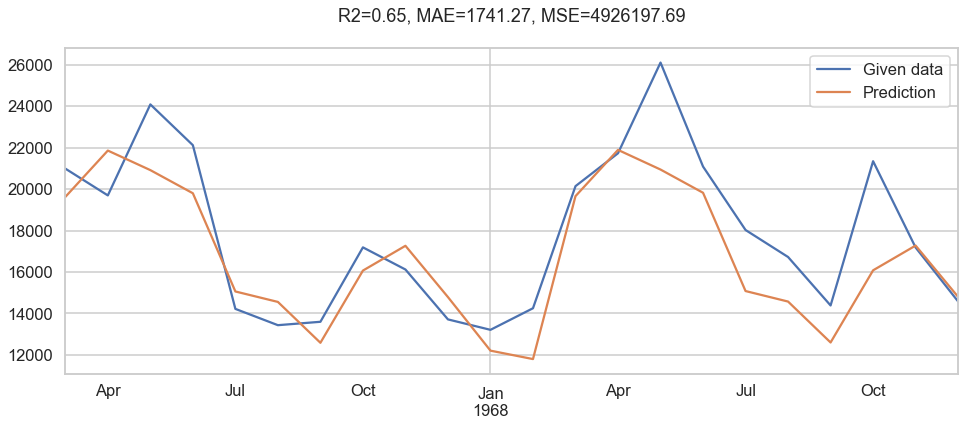

In [68]:
r2 = np.round(r2_score(test["Sales"], predictions),2)
mae = np.round(mean_absolute_error(test["Sales"], predictions),2)
mse = np.round(mean_squared_error(test["Sales"], predictions),2)

test["Sales"].plot(label="Given data")
predictions.plot(label="Prediction")
plt.legend()
plt.title(f"R2={r2}, MAE={mae}, MSE={mse}\n")
plt.show()

Auto_SARIMA determined the model parameters worse than we did manually above.